In [1]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold


In [2]:

# df_TagDesc = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\CSV\Not for Processing\TagDesc.csv')

# df_All_1 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\1 Preprocess\Merge Data\contData_all_Avg_1o2.csv')
# df_All_2 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\1 Preprocess\Merge Data\contData_all_Avg_2o2.csv')
# # Concatenate (union) the dataframes
# df_All = pd.concat([df_All_1, df_All_2], ignore_index=True)

df_All = pd.read_csv(r'C:\Users\austinsh\Project-OptiC4\III Models\3 Model C10\5 Preprocessing - Slecected Features\Merge Data\merged_data.csv')

print(df_All.head())


                  Date  425_pct_Al   M_Value  C4_pct_Eth  C4_pct_H2O  \
0  2012-05-14 07:00:00     6.26763  3.551350    2.353670    21.66280   
1  2012-05-14 08:00:00     6.26798  3.551080    2.355025    21.66545   
2  2012-05-14 09:00:00     6.26868  3.550545    2.357740    21.67070   
3  2012-05-14 10:00:00     6.26938  3.550010    2.360455    21.67595   
4  2012-05-14 11:00:00     6.27008  3.549475    2.363170    21.68125   

   HydWtr_pct_Ammonia  C4_pct_Hex  HydWtr_Na2O   Decanol      FC55003  \
0            0.519068    0.620812     1.088680  0.959336  6332.030000   
1            0.553096    0.621150     1.084100  0.959336  6332.030000   
2            0.621152    0.621824     1.074945  0.959336  6332.030000   
3            0.667952    0.622498     1.065790  0.933602  6191.103333   
4            0.693497    0.623173     1.056635  0.907868  6081.507500   

     FC55009       FC55552      FC55569  FFC55553  FFC55555    LC90366  \
0  2512.3700  41080.000000  6432.660000  1.000685  0.7

In [3]:
# Set max columns to display
pd.set_option('display.max_columns', None)

In [4]:
# # # List of columns to exclude to run XGboost feature selection
# exclude_columns = [
#                #  'Date',
                
#                 # Round 1
#                 'TI40050',
#                 'TC55555',
#                 'LC55568',
#                 'LC55557',
#                 'Al2O3',
#                 'LC55553',

#                 # Round 2
#                 'FC55576',
#                 'PI55004',

#                 # Round 3 - Excluding this one because OLS and FSF agree, but it wasn't captured by XGB-FS
#                 'DI55580',

#                 #Round 4 - Round 3 dropped another in XGB-FS
#                 'LC52572'
                
#                 # 'M_Value',
#                 # 'FFC55553',
#                 # 'DI55580',
#                 # 'Al2O3',
#                 # 'C4_pct_Hex',
#                 # 'LC52572'

#                    ]

# # # Create a new DataFrame without the excluded columnsd
# df_All = df_All.drop(columns=exclude_columns)

# print(df_All.head())

In [5]:
df_All.columns

Index(['Date', '425_pct_Al', 'M_Value', 'C4_pct_Eth', 'C4_pct_H2O',
       'HydWtr_pct_Ammonia', 'C4_pct_Hex', 'HydWtr_Na2O', 'Decanol', 'FC55003',
       'FC55009', 'FC55552', 'FC55569', 'FFC55553', 'FFC55555', 'LC90366',
       'LC90368', 'PI55020', 'TC55552', 'TI55021'],
      dtype='object')

In [6]:
# df_All = df_All[df_All['Date'] > '2020-06-15 00:00:00']

In [7]:
# df_All.drop('Date', axis=1, inplace=True)




In [8]:
print(df_All.describe())

         425_pct_Al       M_Value    C4_pct_Eth    C4_pct_H2O  \
count  52974.000000  52974.000000  52974.000000  52974.000000   
mean       6.145939      3.590823      1.204019     21.209348   
std        0.254677      0.176865      0.689281      2.735901   
min        5.167535      1.347070      0.080626      7.932310   
25%        6.004946      3.500930      0.623279     18.876100   
50%        6.141118      3.586043      1.097525     21.481425   
75%        6.289489      3.678295      1.664852     23.292687   
max        7.131650      5.827565     11.732650     35.028700   

       HydWtr_pct_Ammonia    C4_pct_Hex   HydWtr_Na2O       Decanol  \
count        52974.000000  52974.000000  52974.000000  52974.000000   
mean             0.971848      0.460162      0.813779      3.179127   
std              0.152671      0.237337      0.709024      1.636934   
min              0.369965      0.000006      0.002854      0.087500   
25%              0.877023      0.340993      0.452738      

In [9]:
# Assuming your data is in filtered_df and you want to predict 'target_column_name'
X = df_All.drop(['Decanol', 'Date'], axis=1)  # Replace 'target_column_name' with your target column's name
y = df_All['Decanol']

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Initialize and train the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective ='reg:squarederror', 
    learning_rate=0.05,
    n_estimators=800,
    max_depth=10,
    subsample=0.6,
    colsample_bytree=1,
    gamma=0,
    alpha=0.1,
    reg_lambda=1.5,
    colsample_bylevel=0.8,
    colsample_bynode=0.7
)
xgb_model.fit(X_train, y_train)

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=0.7, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, ...)

In [12]:
# Predict on training data
y_train_pred = xgb_model.predict(X_train)

# Evaluate the model on training data
mse_train = mean_squared_error(y_train, y_train_pred)
print(f"Mean Squared Error on Training Data: {mse_train}")



# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the Testing Data: {mse}")

rmse_train = np.sqrt(mse_train)
print(f"Root Mean Squared Error on Training Data: {rmse_train}")


rmse = np.sqrt(mse)
print(f"Root Mean Squared Error on the Testing Data: {rmse}")

# Calculate R-squared
r2_train = r2_score(y_train, y_train_pred)
print(f"R-squared value on Training Data:: {r2_train:.2f}")


# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared value on the Testing Data: {r2:.2f}")

current_features = X.columns.tolist()

# Calculate Adjusted R-squared
def adjusted_r2(r2, n, k):
    """
    Compute the adjusted R^2 from R^2, number of samples (n) and number of predictors (k).
    
    Args:
    - r2 (float): R^2 value
    - n (int): number of samples
    - k (int): number of predictors

    Returns:
    - float: adjusted R^2 value
    """
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)


adj_r2 = adjusted_r2(r2, len(y_test), len(current_features))

print(f"Adjusted R^2 value: {adj_r2}")

Mean Squared Error on Training Data: 0.0030815102049415563
Mean Squared Error on the Testing Data: 0.05153626163414029
Root Mean Squared Error on Training Data: 0.055511352036692066
Root Mean Squared Error on the Testing Data: 0.22701599422538557
R-squared value on Training Data:: 1.00
R-squared value on the Testing Data: 0.98
Adjusted R^2 value: 0.9805655305257013


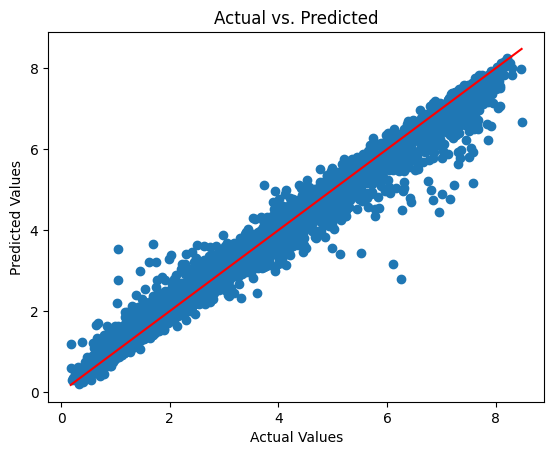

In [13]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')

# Calculate the min and max values across both y_test and y_pred
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))

# Plot the red 1:1 line
plt.plot([min_val, max_val], [min_val, max_val], color='red')  # 1:1 line

plt.show()


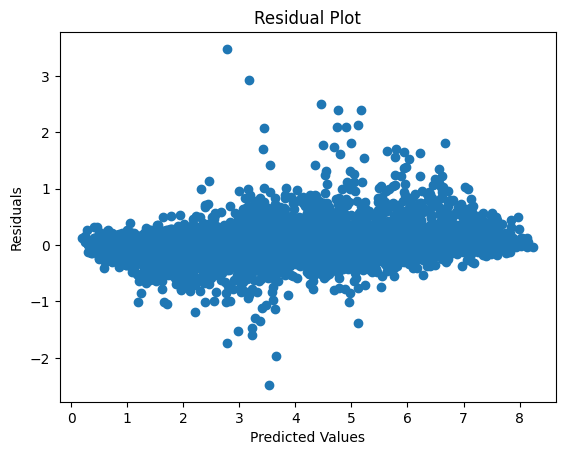

In [14]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [15]:
num_rows = df_All.shape[0]

splits = num_rows//10000

if splits < 5:
    splits = 5

In [16]:
# Define the K-fold cross validator
kfold = KFold(n_splits=splits, shuffle=True, random_state=42)

# Perform K-fold cross-validation
scores = cross_val_score(xgb_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

# Take the square root of the scores to get the RMSE
rmse_scores = np.sqrt(-scores)

# Print out the results
print(f'Scores for each fold are: {rmse_scores}')
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'Standard deviation of RMSE: {np.std(rmse_scores)}')

Scores for each fold are: [0.26228466 0.24586157 0.24821026 0.25910612 0.25723212]
Average RMSE: 0.2545389453583362
Standard deviation of RMSE: 0.006378987553143528


In [17]:
df_All.columns

Index(['Date', '425_pct_Al', 'M_Value', 'C4_pct_Eth', 'C4_pct_H2O',
       'HydWtr_pct_Ammonia', 'C4_pct_Hex', 'HydWtr_Na2O', 'Decanol', 'FC55003',
       'FC55009', 'FC55552', 'FC55569', 'FFC55553', 'FFC55555', 'LC90366',
       'LC90368', 'PI55020', 'TC55552', 'TI55021'],
      dtype='object')

In [18]:
import pickle

# Assuming your model is trained and stored in xgb_model as shown in your code

# Save the model to disk
filename = 'C10_xgb_model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))

print("Model saved successfully.")


Model saved successfully.
